# Comparison of results and choice of hyper_params. 


In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.Data import DataMaker
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import train_test_split
from return_stats import *
from create_plots import *
import pickle
import time
from pydmd import DMD
from tensorflow import keras


plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

# Step 1: Read in a random test batch. 

In [18]:
training_data = pickle.load(open('./data/dataset_discrete.pkl', 'rb'))
input_data = training_data.data_val

In [21]:
# ======================================================================================================================
# Prepare dataset. 
# ======================================================================================================================
data_train, data_test= train_test_split(input_data, test_size=0.0256, random_state=42)

print("dimensions of training dataset (ic x phys_dim x timesteps) = ", np.shape(data_train))
print("dimensions of testing dataset (ic x phys_dim x timesteps) = ", np.shape(data_test))

dimensions of training dataset (ic x phys_dim x timesteps) =  (9744, 2, 251)
dimensions of testing dataset (ic x phys_dim x timesteps) =  (256, 2, 251)


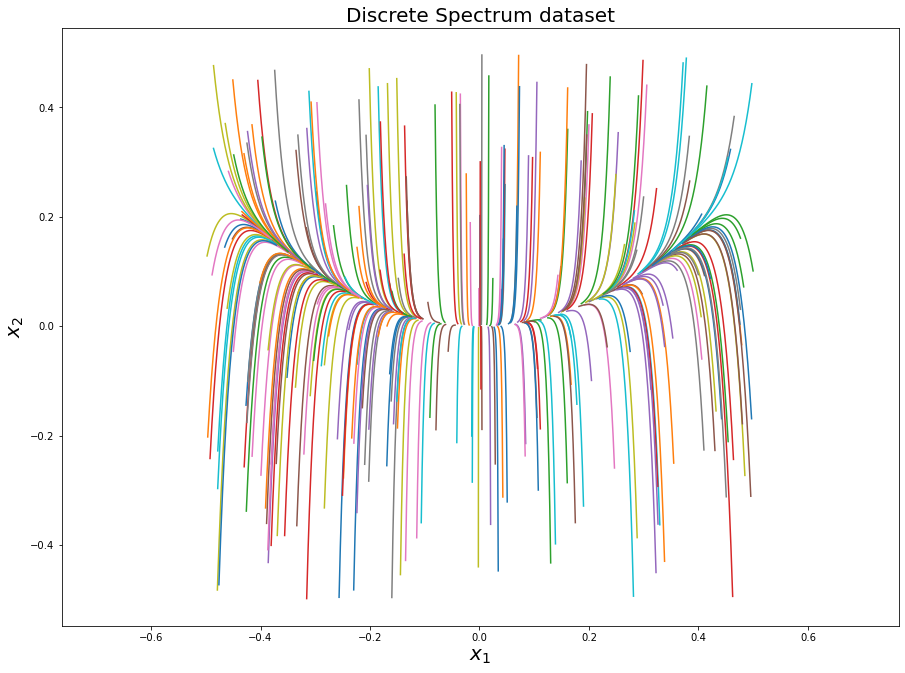

In [22]:
_ = plt.figure(figsize=(15,11))
for ii in np.arange(0, 256, 1):
    plt.plot(data_test[ii, 0, :], data_test[ii, 1, :])
plt.xlabel("$x_{1}$", fontsize=20)
plt.ylabel("$x_{2} $", fontsize=20)
plt.title("Discrete Spectrum dataset", fontsize=20)
plt.axis("equal")
plt.show()

# Step 2: Load a saved model. 

In [48]:
# Network Hyper Parameters
hyp_params = dict()
hyp_params['num_t_steps'] = training_data.params['num_time_steps']
hyp_params['phys_dim'] = training_data.params["num_physical_dim"]
hyp_params['num_init_conds'] = training_data.params['num_initial_conditions']
hyp_params['batch_size'] = 256
hyp_params['num_epochs'] = 200

# Encoding/Decoding Layer Parameters.
hyp_params['num_en_layers'] = 4
hyp_params['num_en_neurons'] = 50
hyp_params['latent_dim'] = 3
hyp_params['window_size'] = 256

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'
hyp_params['regfac'] = 3e-3

hyp_params['c1'] = 1 # coefficient autoencoder loss
hyp_params['c2'] = 10 # coefficient of dmd loss. 
hyp_params['c3'] = 10 # dmd reconstruction weight. 


In [49]:
myMachine = DMDMachine(hyp_params)

# Linearity evaluation of data set:

In [47]:
print("DMD Loss on input dataset = ", (myMachine.get_linearity_loss(tf.convert_to_tensor(data_test)).numpy()))
y_pred_reshape =  DMDMachine.compute_predict_batch_reshape(myMachine, y_data_mat=tf.convert_to_tensor(data_test))
print("Pred Loss on input dataset = ", (myMachine.pred_loss(tf.convert_to_tensor(data_test), y_pred_reshape)).numpy())

DMD Loss on input dataset =  1.2005314e-06
Pred Loss on input dataset =  1.1933484e-11


# Linearity evaluation of latent space of saved models:

In [50]:
myMachine.autoencoder.encoder = keras.models.load_model("./models/encAeEx1_2020-12-16", compile=False)
myMachine.autoencoder.decoder = keras.models.load_model("./models/decAeEx1_2020-12-16", compile=False)

## Step 3: plot results.

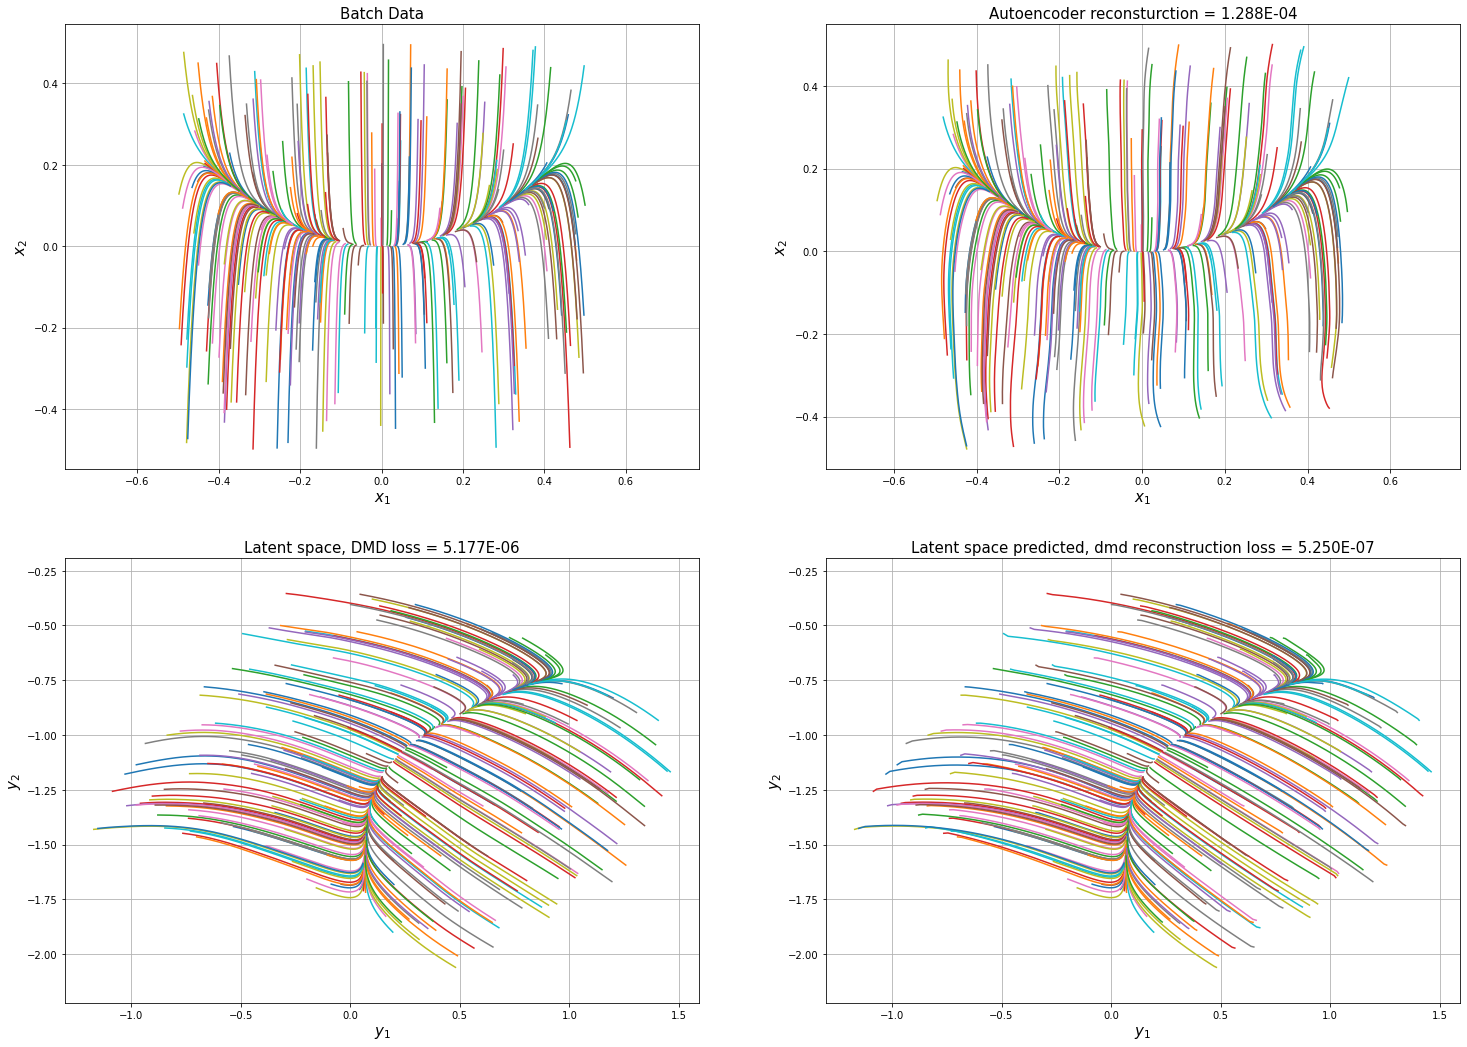

In [51]:
test_run = myMachine(data_test)

new_plot_model(test_run, data_test)

# Step 4: Repeat for all models saved. 

In [18]:
# Network Hyper Parameters
hyp_params = dict()
hyp_params['num_t_steps'] = 101
hyp_params['phys_dim'] = 2
hyp_params['num_init_conds'] = 10000
hyp_params['batch_size'] = 256 # MAJOR PARAMETER CHOICE
hyp_params['num_epochs'] = 200  # MAJOR PARAMETER CHOICE
hyp_params["window_size"] = None

# Encoding/Decoding Layer Parameters
hyp_params['num_en_layers'] = 4 # MAJOR PARAMETER CHOICE
hyp_params['num_en_neurons'] = 32  # MAJOR PARAMETER CHOICE
hyp_params['latent_dim'] = 2

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'
hyp_params['regfac'] = 3e-3

hyp_params['c1'] = 1 # coefficient autoencoder loss
hyp_params['c2'] = 10 # coefficient of dmd loss. 
hyp_params['c3'] = 10 # dmd reconstruction weight. 

In [19]:
myMachine = DMDMachine(hyp_params)

dmd loss =  tf.Tensor(0.00030063427, shape=(), dtype=float32)
pred loss =  tf.Tensor(0.00027030753, shape=(), dtype=float32)


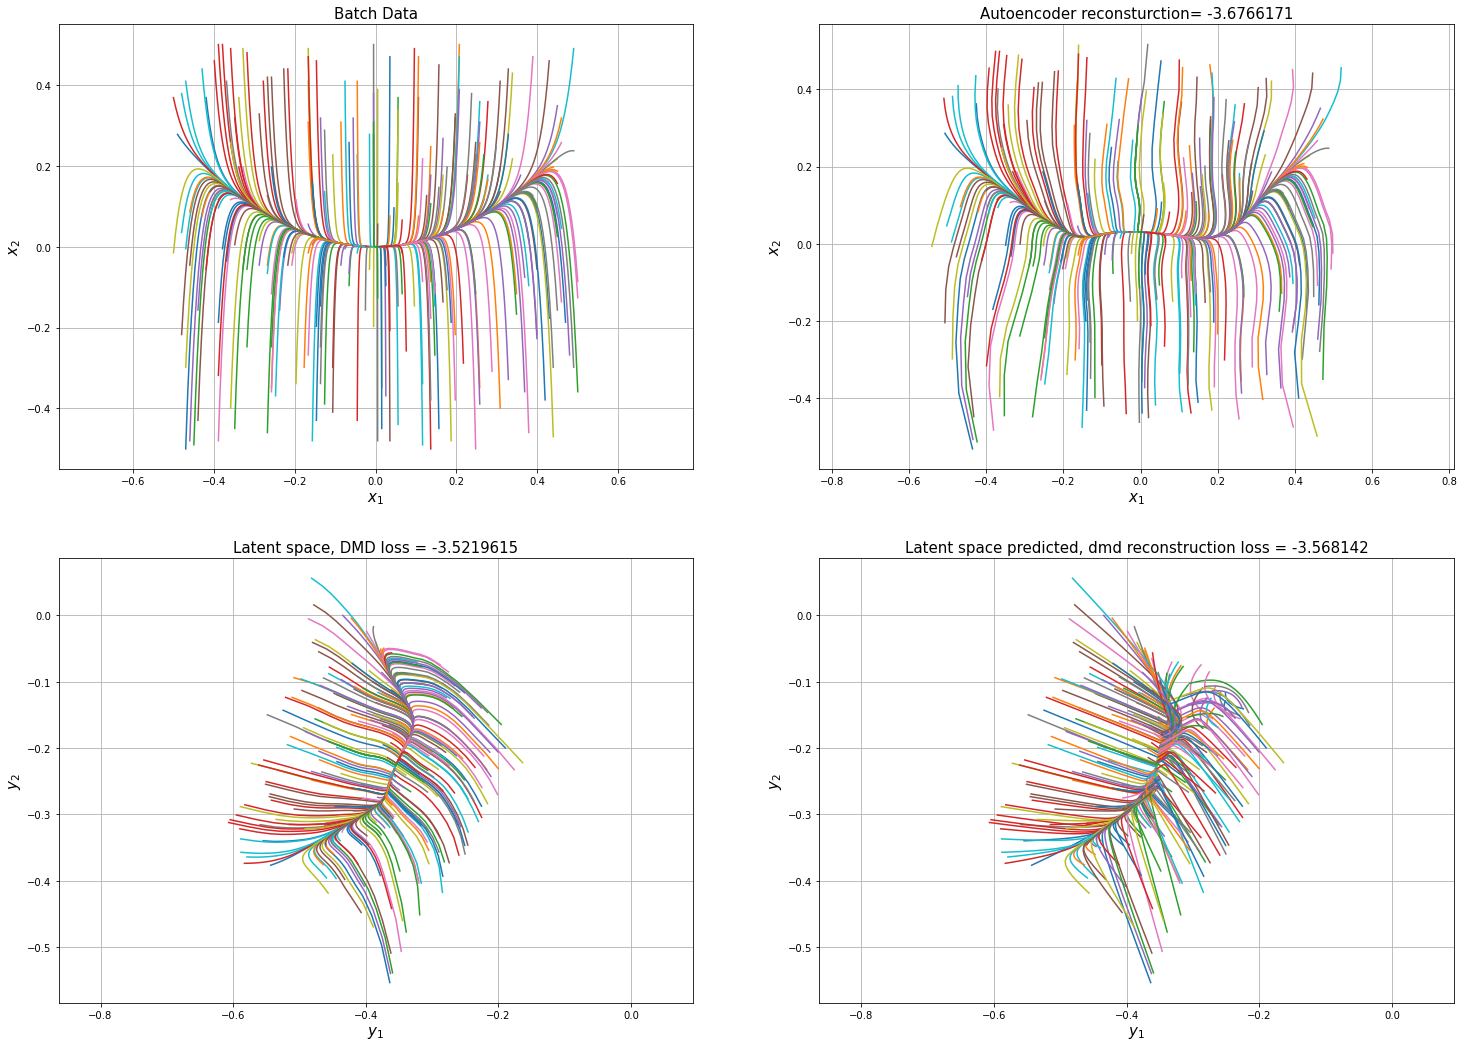

In [20]:
myMachine.autoencoder = keras.models.load_model("models/my_model_Ex1_oct23", compile=False)
test_run = myMachine(random_batch2)


print("dmd loss = ", test_run[2])
print("pred loss = ", test_run[5])
new_plot_model(test_run, random_batch2)

In [21]:
print("DMD Loss on input dataset = (log scale")
print(myMachine.get_linearity_loss(tf.convert_to_tensor(random_batch2)).numpy())

DMD Loss on input dataset = (log scale
0.0003278027


In [22]:
y_pred2 = np.zeros((hyp_params["batch_size"], hyp_params["phys_dim"], hyp_params["num_t_steps"]))
for ii in range(0, hyp_params["batch_size"]):
    dmd = DMD(svd_rank=2)
    dmd.fit(X=random_batch2[ii, :, :])
    y_pred2[ii, :, :] = dmd.reconstructed_data.real
y_pred2.shape

(256, 2, 101)

In [23]:
print("Pred Loss input dataset= (log scale) ")
print(myMachine.pred_loss(tf.convert_to_tensor(random_batch2), tf.convert_to_tensor(y_pred2)).numpy())

Pred Loss input dataset= (log scale) 
5.055053946597122e-05
